In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
import torchvision.datasets as datasets

# 다운로드받을 디렉토리
data_root = './data'

train_set0 = datasets.MNIST(
    root=data_root, # 원본 데이터를 다운로드받을 디렉토리
    train=True, # 훈련 데이터인지 또는 검증 데이터인지
    download=True) # 원본 데이터가 없는 경우, 다운로드를 실행하는지 여부

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.54MB/s]


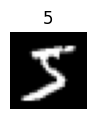

In [7]:
image = train_set0[0][0]
label = train_set0[0][1]
plt.figure(figsize=(1, 1))
plt.title(f'{label}')
plt.imshow(image, cmap='gray')
plt.axis('off') # 축 제거
plt.show()

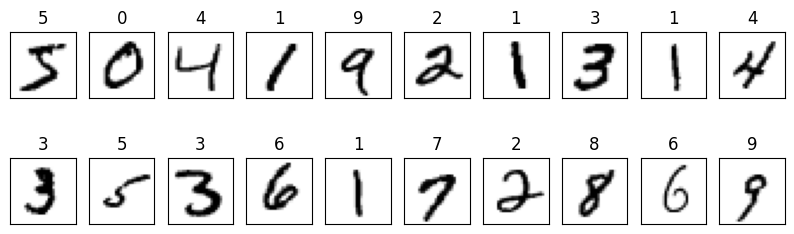

In [9]:
plt.figure(figsize=(10, 3))
for i in range(20):
  ax = plt.subplot(2, 10, i+1)
  image, label = train_set0[i]

  plt.title(f'{label}')
  plt.imshow(image, cmap='gray_r')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
import torchvision.transforms as transforms

transfrom1 = transforms.Compose([
    transforms.ToTensor(), # 이미지 데이터를 텐서로 변환하는 코드
])

train_set1 = datasets.MNIST(
    root = data_root, train = True, download = True,
    transform = transfrom1) # 기존 데이터를 받아오는 코드에서 텐서 변환 코드를 삽입함

In [12]:
# 변환 결과 확인

image, label = train_set1[0]
print('입력 데이터 타입: ', type(image))
print('입력 데이터 shape: ', image.shape)
print('최솟값: ', image.data.min())
print('최댓값: ', image.data.max())

입력 데이터 타입:  <class 'torch.Tensor'>
입력 데이터 shape:  torch.Size([1, 28, 28])
최솟값:  tensor(0.)
최댓값:  tensor(1.)


In [14]:
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1))
])

train_set2 = datasets.MNIST(
    root = data_root, train = True, download = True,
    transform = transform2)

### 데이터 정규화
- transforms.Normalize(): 각 채널별 평균(mean)을 뺀 뒤 표준편차(std)로 나누어 정규화를 진행
- transofrms.Normalize((R채널 평균, G채널 평균, B채널 평균), (R채널 표준편차, G채널 표준편차, B채널 표준편차))
로 입력하여 적용
변환 후 결과는 각 채널별 이미지 픽셀 값을 채널별 평균을 뺀 뒤 표준편차로 나누어 계산
현재 데이터는 흑백이므로 transofrms.Normalize(평균, 표준편차)로 변환
즉, 변환 후 결과 = (픽셀 값 – 평균) / (표준편차)

In [15]:
image, label = train_set2[0]
print('shape: ', image.shape)
print('최솟값: ', image.data.min())
print('최댓값: ', image.data.max())

shape:  torch.Size([784])
최솟값:  tensor(-1.)
최댓값:  tensor(1.)


In [16]:
# 훈련용 데이터셋 정의
train_set = datasets.MNIST(
    root = data_root, train = True, download = True,
    transform = transform2)

# 검증용 데이터셋 정의
test_set = datasets.MNIST(
    root = data_root, train = False, download = True,
    transform = transform2)

In [17]:
from torch.utils.data import DataLoader

# 미니 배치 사이즈 지정
batch_size = 512
# 훈련용 데이터로더
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
# 검증용 데이터로더
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = False)

In [18]:
print(len(train_loader))

# 데이터로더부터 가장 처음 한 세트를 가져옴
for images, labels in train_loader:
  break

print(images.shape)
print(labels.shape)

118
torch.Size([512, 784])
torch.Size([512])


```
118
torch.Size([512, 784])
torch.Size([512])
```
Data가 6만개, batch_size=512이고,
60000/512=117.1875이므로 미니배치의 개수는 118개이다

### 모델 정의
#### nn.Module()을 상속하여 정의받는 방법
파이토치에서 nn.Module을 상속받는 모델은 기본적으로 _ _init_ _()과 forward() 함수를 포함
_ _init_ _()에서는 모델에서 사용될 모듈(nn.Linear, nn.Conv2d), 활성화 함수 등을 정의하고,
forward() 함수에서는 모델에서 실행되어야 하는 연산을 정의

```python
class MLP(Module):
  def __init__(self, inputs):
    super(MLP, self).__init__()
    self.layer = Linear(inputs, 1)
    self.activation = Sigmoid()

  def forward(self, X):
    X = self.layer(X)
    X = self.activation(X)
    return X
```

In [20]:
# 입력 차원수
n_input = image.shape[0]

# 출력 차원수 = 분류 클래스 수 = 10
n_output = len(labels.unique()) # unique 함수는 변수안의 모든 종류의 값을 1개만 도출한다.

# 은닉층의 노드 수
n_hidden = 128

In [49]:
# 모델 정의
# 784입력 10출력 1은닉층의 신경망 모델

class Net(nn.Module):
  def __init__(self, n_input, n_hidden, n_output): # 신경망 기본 구성 정의
    super().__init__()

    # 은닉층 정의(은닉층 노드 수: n_hidden)
    self.l1 = nn.Linear(n_input, n_hidden)

    # 출력층 정의
    self.l2 = nn.Linear(n_hidden, n_output)

    # ReLU
    self.relu = nn.ReLU()

  def forward(self, x): # 순전파 계산 및 순서 정의
    x1 = self.l1(x)
    x2 = self.relu(x1)
    x3 = self.l2(x2)
    return x3

In [50]:
# 모델 인스턴스 생성
net = Net(n_input, n_output, n_hidden)

# 모델을 GPU로 전송
net = net.to(device)

In [30]:
# 모델 내부 파라미터 확인
# l1.weight, l1.bias, l2.weight, l2.bias를 확인할 수 있음

for parameter in net.named_parameters():
  print(parameter)

('l1.weight', Parameter containing:
tensor([[-0.0308,  0.0278,  0.0085,  ..., -0.0094, -0.0331,  0.0249],
        [ 0.0219, -0.0151,  0.0120,  ...,  0.0126, -0.0231, -0.0229],
        [-0.0211, -0.0107,  0.0313,  ..., -0.0230,  0.0267, -0.0152],
        ...,
        [ 0.0117, -0.0095,  0.0002,  ...,  0.0009,  0.0123,  0.0254],
        [-0.0036, -0.0346, -0.0057,  ..., -0.0098,  0.0151, -0.0314],
        [-0.0282,  0.0094, -0.0191,  ..., -0.0173,  0.0206,  0.0304]],
       device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0023,  0.0089,  0.0084,  0.0127, -0.0002,  0.0147,  0.0254,  0.0165,
         0.0092,  0.0194], device='cuda:0', requires_grad=True))
('l2.weight', Parameter containing:
tensor([[-2.4200e-01, -9.1138e-02,  2.5679e-01,  ..., -2.0645e-01,
         -3.1183e-01,  2.1307e-02],
        [ 1.2794e-02,  1.4707e-01, -8.5781e-02,  ...,  3.3429e-02,
          2.2282e-01, -2.3049e-01],
        [-1.2133e-02, -2.7330e-01, -5.2975e-02,  ...,  1.4177e-0

In [31]:
# 심플하게 print로 확인 가능
print(net)

Net(
  (l1): Linear(in_features=784, out_features=10, bias=True)
  (l2): Linear(in_features=10, out_features=128, bias=True)
  (relu): ReLU()
)


In [32]:
!pip install torchinfo | tail -n 1
from torchinfo import summary

In [51]:
summary(net, input_size=(512, 784)) # 실제 학습할 때 넣는 데이터의 크기 지정

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [512, 128]                --
├─Linear: 1-1                            [512, 10]                 7,850
├─ReLU: 1-2                              [512, 10]                 --
├─Linear: 1-3                            [512, 128]                1,408
Total params: 9,258
Trainable params: 9,258
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.74
Input size (MB): 1.61
Forward/backward pass size (MB): 0.57
Params size (MB): 0.04
Estimated Total Size (MB): 2.21

In [52]:
# 난수 고정
torch.cuda.manual_seed(123)

# 학습률
lr = 0.01

# 최적화 알고리즘: 경사하강법
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# 손실 함수: 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 평가 결과 기록
history = np.zeros((0, 5))

In [54]:
from tqdm.notebook import tqdm

num_epochs = 20

for epochs in range(num_epochs):
  train_acc, train_loss = 0, 0
  test_acc, test_loss = 0, 0
  n_train, n_test = 0, 0

  # 훈련 페이즈
  for inputs, labels in tqdm(train_loader):
    n_train += labels.shape[0]

    # GPU 설정
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad() # Gradient 초기화

    outputs = net(inputs) # 순전파 계산

    loss = criterion(outputs, labels) # 손실값 계산

    loss.backward() # 역전파 계산

    optimizer.step() # 변수 업데이트

    predicted = outputs.max(axis=1)[1] # 실제 예측은 output중에서 가장 높은 값이 있는 위치

    train_loss += loss.item()
    train_acc += (predicted == labels).sum().item() # 예측과 실제값이 같은 것의 개수

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]